# This notebook handles ingestion of stocks data to feature store

In [1]:
# to align client/server mlrun version
# !/User/align_mlrun.sh

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-07-06 11:26:06,823 [info] loaded project stocks from None or context


> <b> Steps </b>
> * [Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json](#Creating-mlrun-function-that-reads-stocks-from-yahoo_fin-and-returning-record-oriented-json)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

In [3]:
# !pip install yahoo_fin

In [4]:
import os

# getting the sentiment analysis pretrained model (433M might take a while)
if not os.path.exists('src/model.pt'): 
    os.makedirs('src',exist_ok=True)
    print('getting model')
    !wget -O src/model.pt https://iguazio-sample-data.s3.amazonaws.com/models/model.pt 
        


# Deploying sentiment analysis serving function

In [5]:
model_location = os.path.abspath('src/model.pt')
sentiment_analysis_serving = mlrun.import_function('hub://sentiment_analysis_serving').apply(mlrun.auto_mount())
sentiment_analysis_serving.add_model('sentiment_analysis_model', model_path=model_location,
                                      class_name='SentimentClassifierServing')

# sentiment_analysis_serving.with_http() # needed to provide http-endpoint to our serving graph

address = sentiment_analysis_serving.deploy()

> 2022-07-06 11:26:22,484 [info] Starting remote function deploy
2022-07-06 11:26:22  (info) Deploying function
2022-07-06 11:26:22  (info) Building
2022-07-06 11:26:22  (info) Staging files and preparing base images
2022-07-06 11:26:22  (info) Building processor image
2022-07-06 11:28:08  (info) Build complete
2022-07-06 11:28:38  (info) Function deploy complete
> 2022-07-06 11:28:39,680 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


## Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json

In [6]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import yahoo_fin.news as ynews
from dateutil import parser
import pandas as pd 
import json
import requests
from storey import MapClass, Event
import string
import mlrun

def print_event(event):    
    sentiment = event.body['outputs']['predictions'][0]/2
    return_event = Event(body={'sentiment': sentiment}, key=event.body['outputs']['meta_data']['ticker'], time=event.body['outputs']['meta_data']['Datetime'])
    return return_event

def wrap_event(event):
    wrapped_event = {'meta_data': {'ticker': event['ticker'], 'Datetime': event['Datetime']}, 'inputs': [event['summary']]}
    return wrapped_event

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def get_news(event):
    '''
    event: dict with the following keys:
    n_stocks - how many stocks to collect
    '''
    tickers = si.tickers_sp500()[:event['n_stocks']]
    tickers_news = []
    for ticker in tickers:
        news = ynews.get_yf_rss(ticker=ticker)
        news_df = pd.DataFrame(news)
        df_copy = news_df[['title','summary','link','published']].copy()
        df_copy['ticker'] = ticker
        df_copy['Datetime'] = df_copy['published'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S'))
        df_copy['summary'] = df_copy['summary'].apply(lambda x:remove_punctuation(x))
        df_copy['title'] = df_copy['title'].apply(lambda x:remove_punctuation(x))
        tickers_news.append(df_copy)
    df = pd.concat(tickers_news).reset_index(drop=True)
    return json.loads(df.to_json(orient='records'))

class sentiment_analysis():
    def __init__(self,address):
        self.address= address    
        
    def do(self,event):
        response = json.loads(requests.put(self.address + "v2/models/sentiment_analysis_model/predict",
                                                     json=json.dumps(event.body)).text)
        sentiment_event = response['outputs']['meta_data']
        sentiment_event['sentiment'] = response['outputs']['predictions'][0]/2 # so it'll be 0 for neg, 0.5 for neutral and 1 for pos
        
        return Event(sentiment_event,key=sentiment_event['ticker'], time=sentiment_event['Datetime'])
    
#mlrun: end-code

## Creating a feature set and declaring the graph

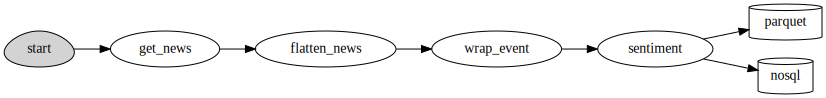

In [7]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("stocks_news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
# n_tickers = 4

news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to("sentiment_analysis", "sentiment", full_event=True, address=address) 

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [8]:
# ingesting dummy (A MUST) 
import os
import datetime

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':4}))

,Datetime,sentiment
ticker,,
A,2022-07-05 12:00:00,0.0
A,2022-07-04 16:01:50,0.5
A,2022-07-01 21:28:09,1.0
A,2022-06-30 13:30:01,0.5
A,2022-06-23 15:30:03,1.0
...,...,...
AAPL,2022-07-05 17:16:00,0.0
AAPL,2022-07-05 16:42:15,0.0
AAPL,2022-07-05 16:25:00,0.5


## Deploying the graph and providing http-endpoint

In [9]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'])

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [10]:
# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-07-06 11:30:37,802 [info] Starting remote function deploy
2022-07-06 11:30:37  (info) Deploying function
2022-07-06 11:30:37  (info) Building
2022-07-06 11:30:38  (info) Staging files and preparing base images
2022-07-06 11:30:38  (info) Building processor image
2022-07-06 11:31:23  (info) Build complete
2022-07-06 11:32:25  (info) Function deploy complete
> 2022-07-06 11:32:25,914 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-news-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


In [15]:
news_set_endpoint

'http://stocks-dani-get-news-stocks-dani.default-tenant.app.vmdev94.lab.iguazeng.com/'

## Testing ingestion service

In [11]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':4})
t.text

'{"id": "ae95e581-979f-4833-8173-391368126bda"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [12]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

Overwriting src/invoker.py


In [13]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 */1 * * *')

> 2022-07-06 11:32:26,190 [info] starting run ingestion-service-news-ingestion_service_invoker uid=8442a7d80b254a0e9d2d4f839e919b7e DB=http://mlrun-api:8080
> 2022-07-06 11:32:26,493 [info] task scheduled, {'schedule': '0 */1 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-news-ingestion_service_invoker'}
